## Signals in the Soils (SiTS) first experimental runs at Reynolds Creek Experimental Watershed

This first set of experimental runs were completed as single point runs at the Reynold Creek Experimental Water (RCEW) using the Community Land Model (CLM). Single point domain and surface data files were created for the Reynold West Mountain (check this) site. The climate was forced using the GSWP3 climate data set. A 600 year spin up was completed, followed by a historic run from 1850 up to 1981. After 1981 the experimental simulations were completed running from 1981 to 2110 with the climate data cycling from 1980 (1981?) through 2009. There were three experimental scenarios:

1. Experiment 0: A control run with default ksat from the surface data files.

2. Experiment 1: A run with ksat set to the maximum *positive* change in ksat based on Hirmas et al. 2018.

3. Experiment 2: A run with ksat set to the maximum *negative* change in ksat based on Hirmas et al. 2018.

Updates were made to the SoilStateInitTimeConstMod.F90, which sets the soil thermal and hydraulic properties. 

Experiment 1, soilstate_inst%**hksat**_col(c,lev)  = (params_inst%hksat_adjustfactor x ( uncon_frac x uncon_hksat + &
                                                   (perc_frac x om_frac) x om_hksat )) x **1.33**
                                       
Experiment 2, soilstate_inst%**hksat**_col(c,lev)  = (params_inst%hksat_adjustfactor x ( uncon_frac x uncon_hksat + &
                                                   (perc_frac x om_frac) x om_hksat )) x **0.54**

### Author: Kaite Murenbeeld
### Date: 21 Spet 2020

### Load appropriate libraries.

In [1]:

from __future__ import print_function
import sys
import os
from getpass import getuser
import string
import subprocess

import netCDF4 as netcdf4
import xarray as xr
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as c
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nc_time_axis
import cftime

from IPython.display import display, Math, Latex, Image

from matplotlib.pyplot import rcParams
from matplotlib.ticker import FormatStrFormatter

from dask_jobqueue import PBSCluster
from dask.distributed import Client

xr.set_options(display_style='text')

### Check your location?

In [2]:
myname=getuser()
pwd=os.getcwd()
print(myname)
print(pwd)

katiem
/glade/u/home/katiem


In [3]:
# Set your working directories and output directories. 

input_dir = "/glade/work/katiem/SITS_runs/Rwe1_CLM50histsp_h1e0_001/lnd/hist/"
input_dir_e1 = "/glade/work/katiem/SITS_runs/Rwe1_CLM50histsp_h1e1_003/lnd/hist/"
input_dir_e2 = "/glade/work/katiem/SITS_runs/Rwe1_CLM50histsp_h1e2_001/lnd/hist/"
fig_dir = "/glade/u/home/katiem/FIGURES/"

### Examining a Time Series from Output

### The Water Budget:

<img src="FIGURES/Single_Point_Water_Budget.png">

#### In these experiments the module did not calculate groundwater recharge or later subsurface flow. Additionally, there was no soil ice. The water buget provides a good context to view the results of the experimentation by looking at the different components of the equation. 

#### * Precipitation (P) = rain + snow - interception (not calculated in this notebook, but will be in the future)
#### * Qin = Infiltration (QINFL)
#### * ET = evapotranspiration (QFLX_EVAP_TOT, this includes the ground evaporation)
#### * Qout = total surface runoff (QRUNOFF)
#### * S = Change in storage. I think this is the sum of liquid water and ice in the soil (SOILLIQ + SOILICE)

#### It is important to note that P, Qin, ET, and Qout are all rates (mm/s) while liquid soil water is an area density $(kg/m^2)$. This is a first pass and look at the data, so I look forward to hearing more suggestions!!



### Read in Surface Runoff (QRUNOFF, rate), Infiltration (QINFL, rate), Ground Evaporation (QSOIL, rate), Total Evapotranspiration (QFLX_EVAP_TOT) . Soil Liquid Water (SOILLIQ, 2d variable for 20 different soil levels) and Soil Matric Potential (SMP, 2d variable for 25 ground levels) will be covered later in the notebook.

In [4]:
files = sorted(glob.glob(input_dir + 'Rwe1_CLM50histsp_h1e0_001.clm2.h0.*-02-01-00000.nc'))
#print(files)
ds_clm_cntrl = xr.open_mfdataset(files, concat_dim='time', parallel=True).chunk({'time': 2400})
    
varname1 = 'QRUNOFF'
varname2 = 'QINFL'
varname3 = 'QSOIL'
varname4 = 'SOILLIQ'
varname5 = 'QFLX_EVAP_TOT'


da_qrunoff_ma_cntrl = ds_clm_cntrl[varname1].groupby('time.year').mean()
da_qinfl_ma_cntrl = ds_clm_cntrl[varname2].groupby('time.year').mean()
da_qevap_ma_cntrl = ds_clm_cntrl[varname3].groupby('time.year').mean()
da_sliq_ma_cntrl = ds_clm_cntrl[varname4].groupby('time.year').mean()
da_et_ma_cntrl = ds_clm_cntrl[varname5].groupby('time.year').mean()

In [6]:
#varname5 = 'QFLX_EVAP_TOT'
#da_et_ma_cntrl = ds_clm_cntrl[varname5].groupby('time.year').mean()

In [5]:
files = sorted(glob.glob(input_dir_e1 + 'Rwe1_CLM50histsp_h1e1_003.clm2.h0.*-02-01-00000.nc'))
#print(files)
ds_clm_e1 = xr.open_mfdataset(files, concat_dim='time', parallel=True).chunk({'time': 2400})
    
varname1 = 'QRUNOFF'
varname2 = 'QINFL'
varname3 = 'QSOIL'
varname4 = 'SOILLIQ'
varname5 = 'QFLX_EVAP_TOT'


da_qrunoff_ma_e1 = ds_clm_e1[varname1].groupby('time.year').mean()
da_qinfl_ma_e1 = ds_clm_e1[varname2].groupby('time.year').mean()
da_qevap_ma_e1 = ds_clm_e1[varname3].groupby('time.year').mean()
da_sliq_ma_e1 = ds_clm_e1[varname4].groupby('time.year').mean()
da_et_ma_e1 = ds_clm_e1[varname5].groupby('time.year').mean()

In [6]:
files = sorted(glob.glob(input_dir_e2 + 'Rwe1_CLM50histsp_h1e2_001.clm2.h0.*-02-01-00000.nc'))
#print(files)
ds_clm_e2 = xr.open_mfdataset(files, concat_dim='time', parallel=True).chunk({'time': 2400})
    
varname1 = 'QRUNOFF'
varname2 = 'QINFL'
varname3 = 'QSOIL'
varname4 = 'SOILLIQ'
varname5 = 'QFLX_EVAP_TOT'


da_qrunoff_ma_e2 = ds_clm_e2[varname1].groupby('time.year').mean()
da_qinfl_ma_e2 = ds_clm_e2[varname2].groupby('time.year').mean()
da_qevap_ma_e2 = ds_clm_e2[varname3].groupby('time.year').mean()
da_sliq_ma_e2 = ds_clm_e2[varname4].groupby('time.year').mean()
da_et_ma_e2 = ds_clm_e2[varname5].groupby('time.year').mean()

#### Set the time values in years for the experiments (should all be the same)

In [7]:
time_cntrl = da_qrunoff_ma_cntrl.coords['year'].values
time_e1 = da_qrunoff_ma_e1.coords['year'].values
time_e2 = da_qrunoff_ma_e2.coords['year'].values

time_cntrl

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
       2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068,
       2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090,
       2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101,
       2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111])

### Begin plotting the data, here I zoom in on the years 1990-2040 for no particular reason except to get a better look.

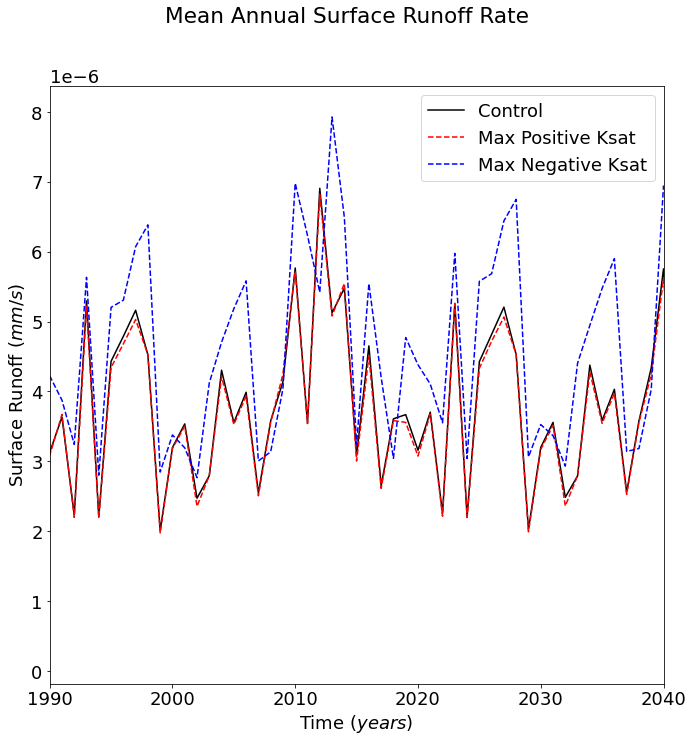

In [9]:
fig1, axs = plt.subplots(figsize=(11, 11), sharex=True)
fig1.suptitle('Mean Annual Surface Runoff Rate')

plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family']='DejaVu Sans'

plt.plot(time_cntrl, da_qrunoff_ma_cntrl, c='k', label='Control')
plt.plot(time_e1, da_qrunoff_ma_e1, 'r--', label='Max Positive Ksat')
plt.plot(time_e2, da_qevap_ma_e2, 'b--', label='Max Negative Ksat')
plt.xlim(1990,2040)
plt.legend()
plt.xlabel('Time ($years$)')
plt.ylabel('Surface Runoff ($mm/s$)')
#plt.title('Mean Annual Surface Runoff Rate')

plt.show()

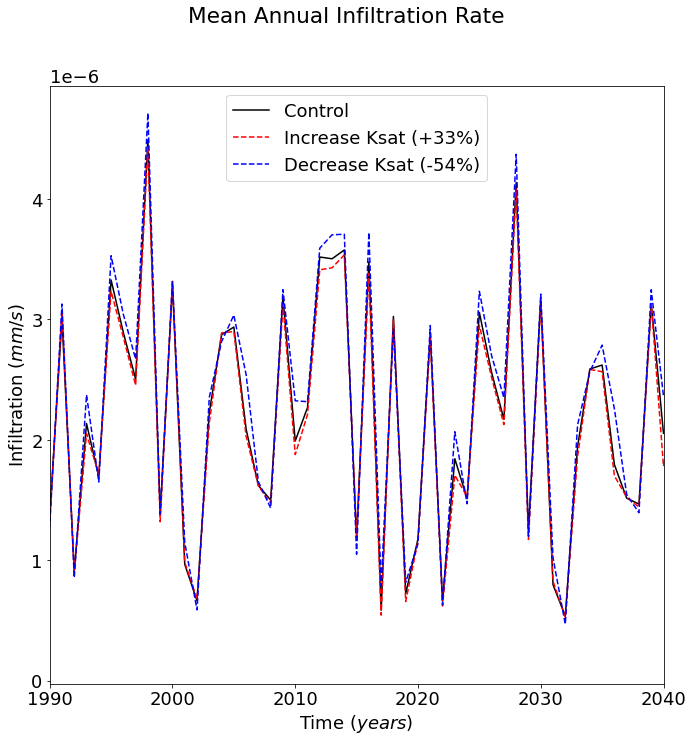

In [10]:
fig2, axs = plt.subplots(figsize=(11, 11), sharex=True)
fig2.suptitle('Mean Annual Infiltration Rate')

plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family']='DejaVu Sans'

plt.plot(time_cntrl, da_qinfl_ma_cntrl,  c='k', label='Control')
plt.plot(time_e1, da_qinfl_ma_e1,  'r--', label='Increase Ksat (+33%)')
plt.plot(time_e2, da_qinfl_ma_e2, 'b--', label='Decrease Ksat (-54%)')
plt.xlim(1990,2040)
plt.legend()
plt.xlabel('Time ($years$)')
plt.ylabel('Infiltration ($mm/s$)')
#plt.title('Mean Annual Infiltration Rate')

plt.show()

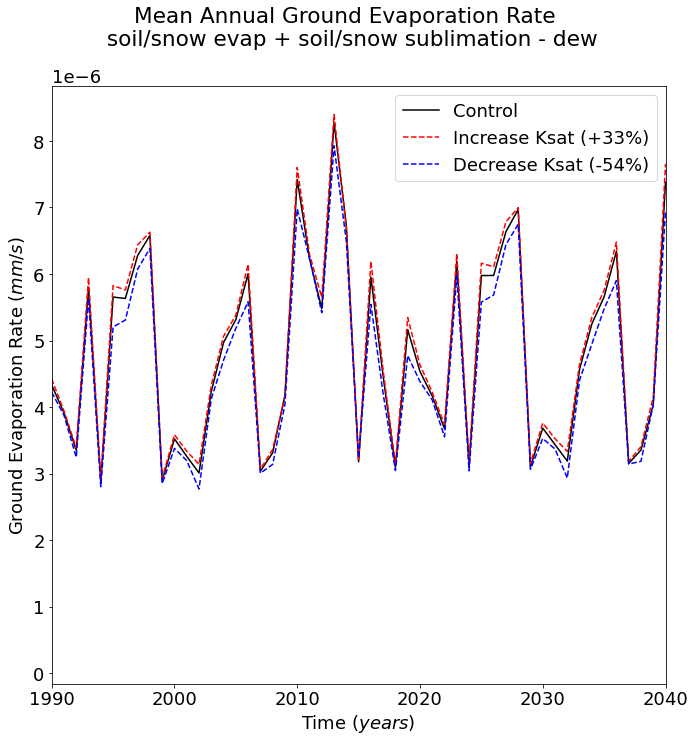

In [11]:
fig3, axs = plt.subplots(figsize=(11, 11), sharex=True)
fig3.suptitle('Mean Annual Ground Evaporation Rate \n soil/snow evap + soil/snow sublimation - dew')

plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family']='DejaVu Sans'

plt.plot(time_cntrl, da_qevap_ma_cntrl, c='k', label='Control')
plt.plot(time_e1, da_qevap_ma_e1, 'r--', label='Increase Ksat (+33%)')
plt.plot(time_e2, da_qevap_ma_e2, 'b--', label='Decrease Ksat (-54%)')
plt.xlim(1990,2040)
plt.legend()
plt.xlabel('Time ($years$)')
plt.ylabel('Ground Evaporation Rate ($mm/s$)') ## Fix this
#plt.title('Mean Annual Ground Evaporation Rate') 

plt.show()

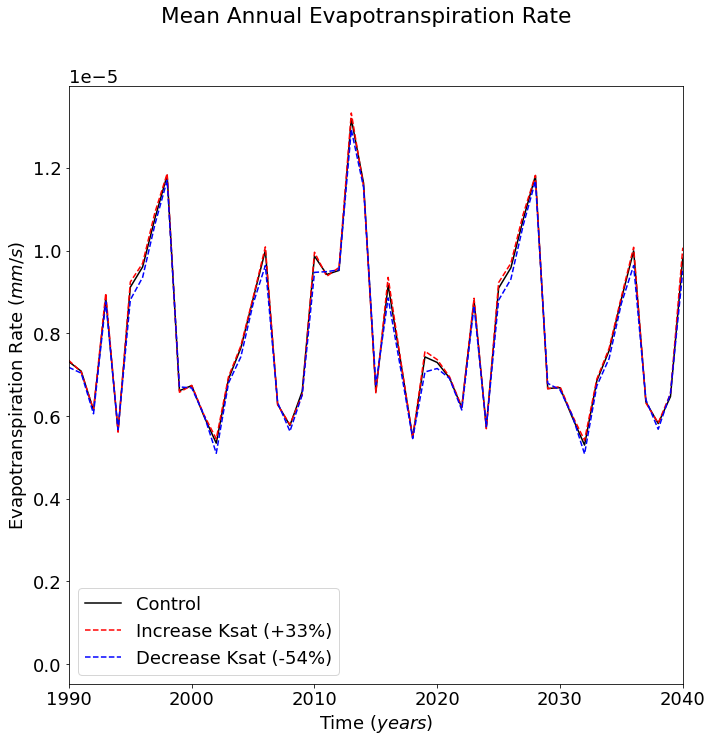

In [12]:
fig4, axs = plt.subplots(figsize=(11, 11), sharex=True)
fig4.suptitle('Mean Annual Evapotranspiration Rate')

plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family']='DejaVu Sans'

plt.plot(time_cntrl, da_et_ma_cntrl, c='k', label='Control')
plt.plot(time_e1, da_et_ma_e1, 'r--', label='Increase Ksat (+33%)')
plt.plot(time_e2, da_et_ma_e2, 'b--', label='Decrease Ksat (-54%)')
plt.xlim(1990,2040)
plt.legend()
plt.xlabel('Time ($years$)')
plt.ylabel('Evapotranspiration Rate ($mm/s$)') ## Fix this
#plt.title('Mean Annual Evapotranspiration Rate') 

plt.show()

#### Calculate the annual mean values for different soil layers for Soil Liquid Water.

In [21]:
da_soilliq_ma_cntrl = ds_clm_cntrl['SOILLIQ'][:,1,:].groupby('time.year').mean()
da_soilliq_ma_e1 = ds_clm_e1['SOILLIQ'][:,1,:].groupby('time.year').mean()
da_soilliq_ma_e2 = ds_clm_e2['SOILLIQ'][:,1,:].groupby('time.year').mean()

da_soilliq_ma_cntrl_2 = ds_clm_cntrl['SOILLIQ'][:,2,:].groupby('time.year').mean()
da_soilliq_ma_e1_2 = ds_clm_e1['SOILLIQ'][:,2,:].groupby('time.year').mean()
da_soilliq_ma_e2_2 = ds_clm_e2['SOILLIQ'][:,2,:].groupby('time.year').mean()

da_soilliq_ma_cntrl_7 = ds_clm_cntrl['SOILLIQ'][:,7,:].groupby('time.year').mean()
da_soilliq_ma_e1_7 = ds_clm_e1['SOILLIQ'][:,7,:].groupby('time.year').mean()
da_soilliq_ma_e2_7 = ds_clm_e2['SOILLIQ'][:,7,:].groupby('time.year').mean()

### Plot the values of some of the different soil layers.

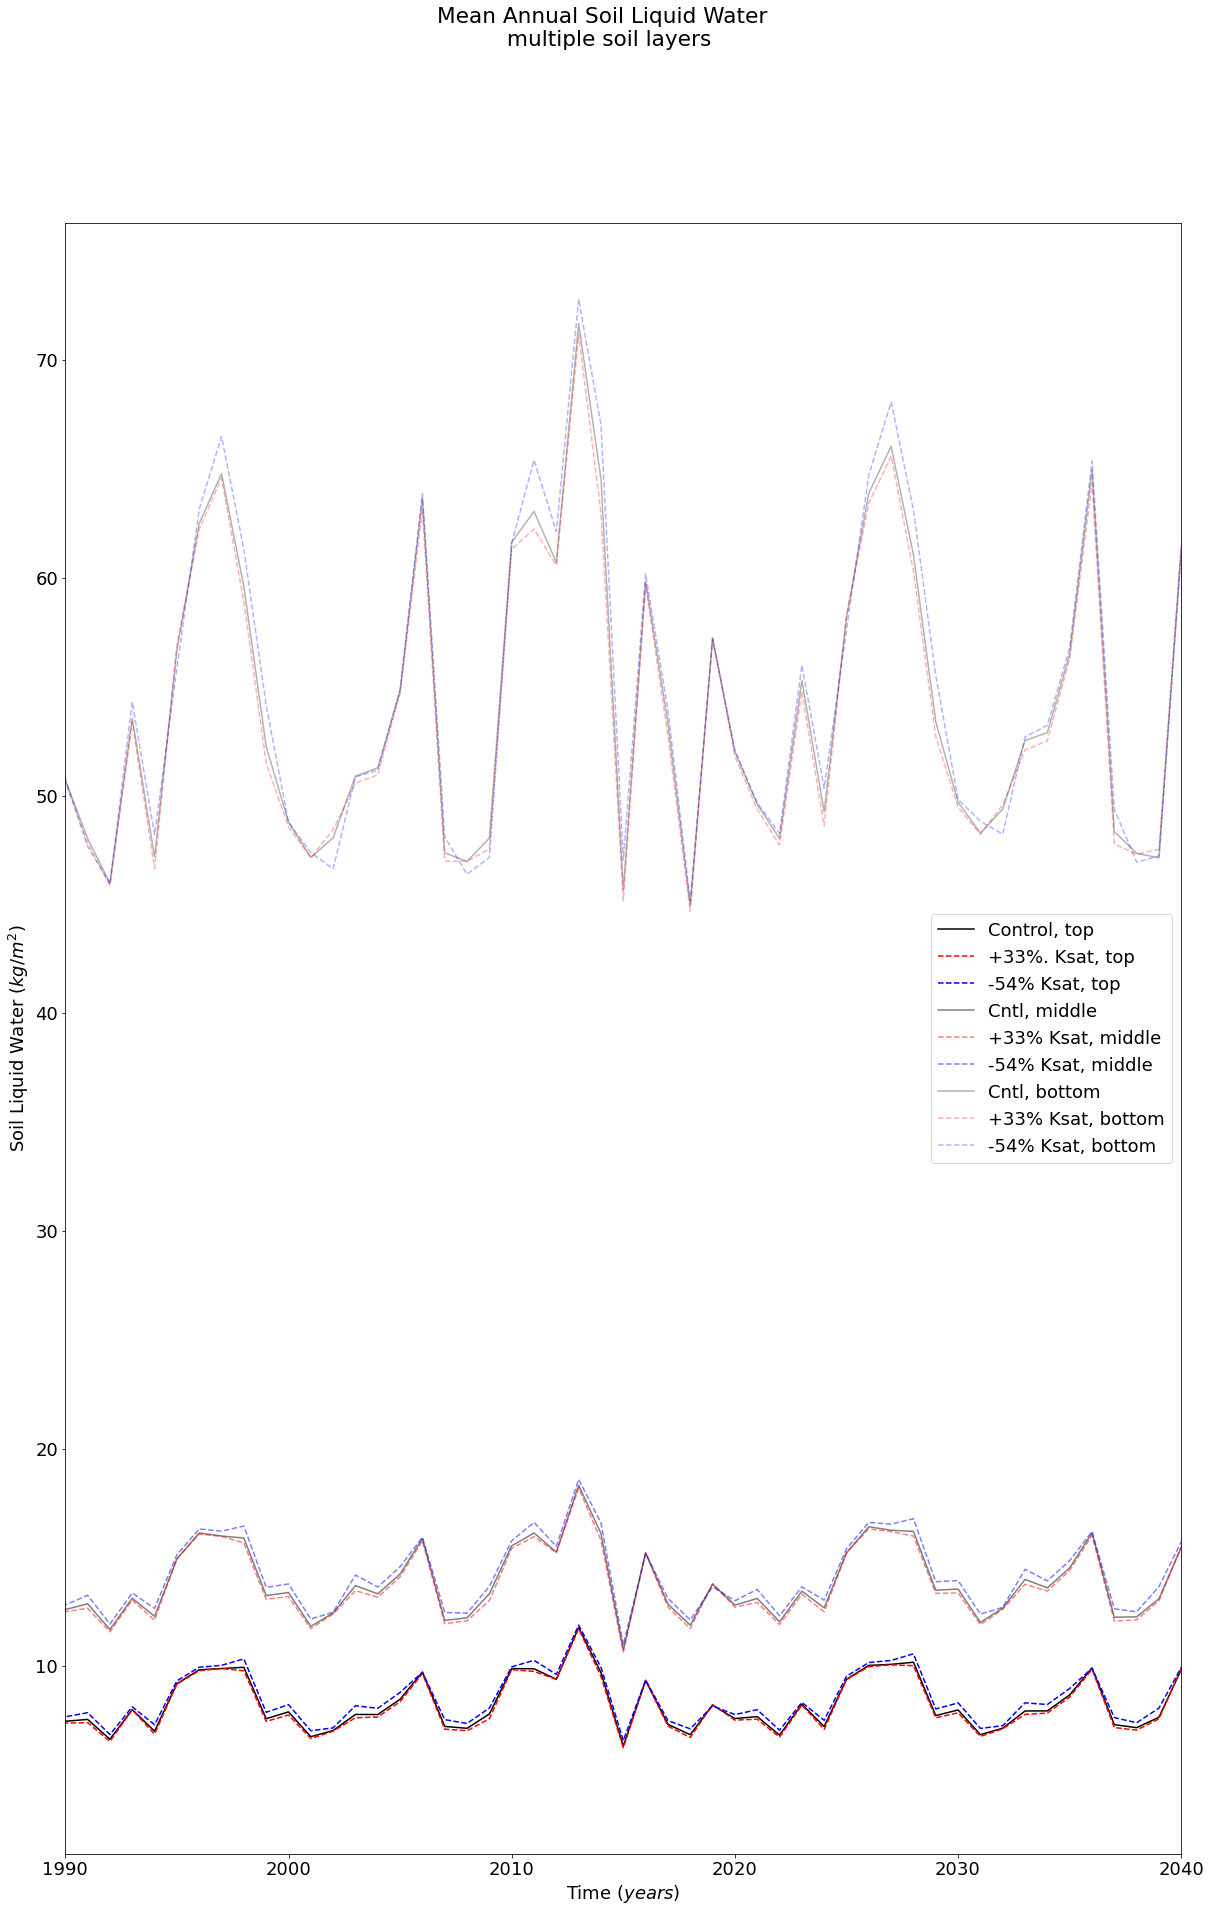

In [22]:
fig5, axs = plt.subplots(figsize=(20, 30), sharex=True)
fig5.suptitle('Mean Annual Soil Liquid Water \n multiple soil layers')

plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family']='DejaVu Sans'

plt.plot(time_cntrl, da_soilliq_ma_cntrl, c='k', label='Control, top')
plt.plot(time_e1, da_soilliq_ma_e1, 'r--', label='+33%. Ksat, top')
plt.plot(time_e2, da_soilliq_ma_e2, 'b--', label='-54% Ksat, top')
plt.plot(time_cntrl, da_soilliq_ma_cntrl_2, c='k', label='Cntl, middle', alpha=0.5)
plt.plot(time_e1, da_soilliq_ma_e1_2, 'r--', label='+33% Ksat, middle', alpha=0.5)
plt.plot(time_e2, da_soilliq_ma_e2_2, 'b--', label='-54% Ksat, middle', alpha=0.5)
plt.plot(time_cntrl, da_soilliq_ma_cntrl_7, c='k', label='Cntl, bottom', alpha=0.3)
plt.plot(time_e1, da_soilliq_ma_e1_7, 'r--', label='+33% Ksat, bottom', alpha=0.3)
plt.plot(time_e2, da_soilliq_ma_e2_7, 'b--', label='-54% Ksat, bottom', alpha=0.3)
plt.xlim(1990,2040)
plt.legend()
plt.xlabel('Time ($years$)')
plt.ylabel('Soil Liquid Water ($kg/m^2$)')
#plt.title('Mean Annual Soil Liquid Water')

plt.show()

#### Calculate the annual mean Soil Matric Potential for the top soil/ground layer.

In [23]:
da_smp_ma_cntrl = ds_clm_cntrl['SMP'][:,1,:].groupby('time.year').mean()
da_smp_ma_e1 = ds_clm_e1['SMP'][:,1,:].groupby('time.year').mean()
da_smp_ma_e2 = ds_clm_e2['SMP'][:,1,:].groupby('time.year').mean()

### Plot the top soil layer Matric Potential.

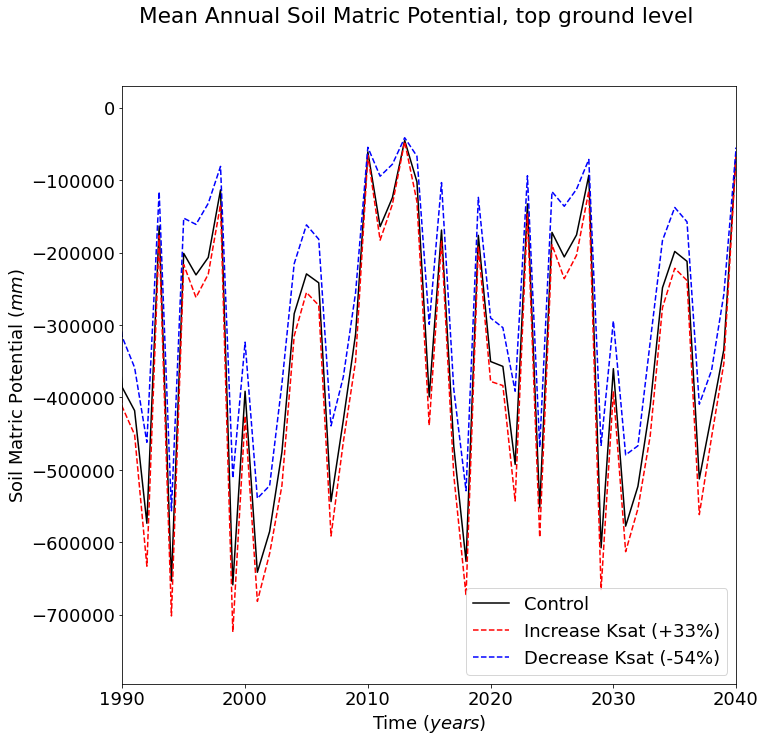

In [24]:
fig6, axs = plt.subplots(figsize=(11, 11), sharex=True)
fig6.suptitle('Mean Annual Soil Matric Potential, top ground level ')

plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family']='DejaVu Sans'

plt.plot(time_cntrl, da_smp_ma_cntrl, c='k', label='Control')
plt.plot(time_e1, da_smp_ma_e1, 'r--', label='Increase Ksat (+33%)')
plt.plot(time_e2, da_smp_ma_e2, 'b--', label='Decrease Ksat (-54%)')
plt.xlim(1990,2040)
plt.legend()
plt.xlabel('Time ($years$)')
plt.ylabel('Soil Matric Potential ($mm$)')
#plt.title('Mean Annual Soil Matric Potential')

plt.show()

### Next Steps!!!